In [1]:
%matplotlib inline
import os
import scipy
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from plotnine import *
import arviz as az
import geopandas
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

# Data

In [2]:
# data
df = pd.read_csv('all_national_indicators.csv')
df.columns = df.columns.str.replace('.', '_')

# add 'un_region_name' and 'un_subregion_2' to Taiwan
df.loc[df.country_name_en =='Taiwan', 'un_region_name'] = 'Asia'
df.loc[df.country_name_en =='Taiwan', 'un_subregion_2'] = 'Eastern Asia'

# new variables
df['mean_aquaculture_production'] = df[['mean_aquaculture_production_freshwater','mean_aquaculture_production_marine','mean_aquaculture_production_brackish']].sum(axis=1)
df['unit_exports'] = df['mean_exports_USD1000'] / df['mean_exports_tonnes']
df['unit_imports'] = df['mean_imports_USD1000'] / df['mean_imports_tonnes']

# log transform highly skewed variables
df['sat_model_est_wealth'] = np.log(df['sat_model_est_wealth'] + 1)
df['eez_total'] = np.log(df['eez_total'] + 1)
df['inland_water_max'] = np.log(df['inland_water_max'] + 1)
df['mean_capture_production'] = np.log(df['mean_capture_production'] + 1)
df['mean_aquaculture_production'] = np.log(df['mean_aquaculture_production'] + 1)
df['unit_exports'] = np.log(df['unit_exports'] + 1)
df['unit_imports'] = np.log(df['unit_imports'] + 1)

# response variable
y = df['fish_supply_daily_g_protein_percap']

# scale by 100/IQR to use the same prior for intercepts across models
q = np.nanquantile(y, [0.25, 0.75])
scale_factor =  100/(q[1] - q[0])
y_scaled = y * scale_factor
y_scaled = y_scaled[~y_scaled.isnull()].copy()

# predictor variables of inetrest
cov = ['mean_educ', 'sat_model_est_wealth', 'gender_equality', 'language_diversity',
    'cultural_hegemony', 'working_percent_un', 'mean_voice_account']

cov_name = ['Education', 'Wealth', 'Gender equality', 'Language diversity',
    'Cultural hegemony', 'Working population', 'Voice and accountability']

x_cov = df[cov].copy()

# nuisance variables
nuisance = ['fish_relative_caloric_price']
x_nuisance = df[nuisance].copy()

# merge
X = x_cov.merge(x_nuisance, left_index=True, right_index=True)

# add population (log) to help impute missing predictors
X['log_pop'] = np.log(df['mean_population']+ 1)

# standardize all predictors
def standardize(x):
    return (x-np.mean(x))/np.std(x)

X = X.apply(standardize, axis=0)
 
# remove predictors without a response variable
X = X.loc[y_scaled.index, :].copy()

In [3]:
X.head()

,mean_educ,sat_model_est_wealth,gender_equality,language_diversity,cultural_hegemony,working_percent_un,mean_voice_account,fish_relative_caloric_price,log_pop
0,0.260914,2.616886,NaN,0.867746,1.133014,3.120179,-0.968561,-0.178496,0.185005
1,NaN,-1.290028,-1.448093,1.140874,-1.061998,-1.578365,-1.158100,NaN,0.782407
2,-0.115912,0.237768,0.033855,0.196442,-1.061998,0.760866,0.170950,1.309397,-0.284405
3,1.696078,0.066650,-0.125038,-1.284376,-1.061998,0.810101,-0.582635,0.697270,-0.285832
4,-1.145520,-0.960004,0.544356,1.002665,-1.061998,-1.873915,-1.075135,-1.187596,0.679610


In [4]:
y_scaled.head()

0    109.908127
1      1.074205
2     25.328622
3     30.982332
4    114.204947
Name: fish_supply_daily_g_protein_percap, dtype: float64

#### _Mask NAs in predictors_

In [5]:
X_masked = np.ma.masked_invalid(X)

#### _Regional and national indices_

In [6]:
region = list(set(df.loc[X.index, 'un_subregion_2']))
region_dict = {x:i for i, x in enumerate(region)}
region_index = [region_dict.get(x) for x in df.loc[X.index, 'un_subregion_2']]
nation_index = list(range(X.shape[0]))

# Model

In [7]:
with pm.Model() as model:

    # global intercept and sd
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    sigma_0 = pm.HalfCauchy('sigma_0', beta=5)

    # regional intercept
    mu_i_offset = pm.Normal('mu_i_offset', mu=0, sigma=1, shape=len(region))
    mu_i = pm.Deterministic('mu_i', mu_0 + mu_i_offset * sigma_0)
    alpha_i = pm.HalfCauchy('alpha_i', beta=5)
    beta_i = pm.HalfCauchy('beta_i', beta=5)
    sigma_i = pm.Gamma('sigma_i', alpha=alpha_i, beta=beta_i, shape=len(region))

    # national intercept
    mu_j_offset = pm.Normal('mu_j_offset', mu=0, sigma=1, shape=X.shape[0])
    mu_j = pm.Deterministic('mu_j', mu_i[region_index] + mu_j_offset[nation_index] * sigma_i[region_index])

    # slope
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1]-1)   # removing log-population

    # error
    sigma = pm.HalfCauchy('sigma', beta=5)

    # impute missing X
    chol, _, _ = pm.LKJCholeskyCov('chol', n=X_masked.shape[1], eta=2, sd_dist=pm.Exponential.dist(lam=1), compute_corr=True)
    cov = pm.Deterministic('cov', chol.dot(chol.T))
    X_mu = pm.Normal('X_mu', mu=0, sigma=100, shape=X.shape[1], testval=X_masked.mean(axis=0))
    X_modeled = pm.MvNormal('X', mu=X_mu, chol=chol, observed=X_masked)

    # observation
    mu = mu_j[nation_index] + tt.dot(X_modeled[:,:-1], beta)   # removing log-population

    # likelihood
    likelihood = pm.StudentT('y', mu=mu, sigma=sigma, nu=5, observed=np.log(y_scaled))

In [8]:
with model:
    trace = pm.sample(5000, tune=1500, chains=2, target_accept=0.95)
    pp = pm.sample_posterior_predictive(trace)
    idata = az.from_pymc3(trace=trace, posterior_predictive=pp)

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


#### _Trace plot_

array([[<AxesSubplot:title={'center':'mu_0'}>,
        <AxesSubplot:title={'center':'mu_0'}>],
       [<AxesSubplot:title={'center':'mu_i'}>,
        <AxesSubplot:title={'center':'mu_i'}>],
       [<AxesSubplot:title={'center':'mu_j'}>,
        <AxesSubplot:title={'center':'mu_j'}>],
       [<AxesSubplot:title={'center':'sigma_0'}>,
        <AxesSubplot:title={'center':'sigma_0'}>],
       [<AxesSubplot:title={'center':'sigma_i'}>,
        <AxesSubplot:title={'center':'sigma_i'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'alpha_i'}>,
        <AxesSubplot:title={'center':'alpha_i'}>],
       [<AxesSubplot:title={'center':'beta_i'}>,
        <AxesSubplot:title={'center':'beta_i'}>]], dtype=object)

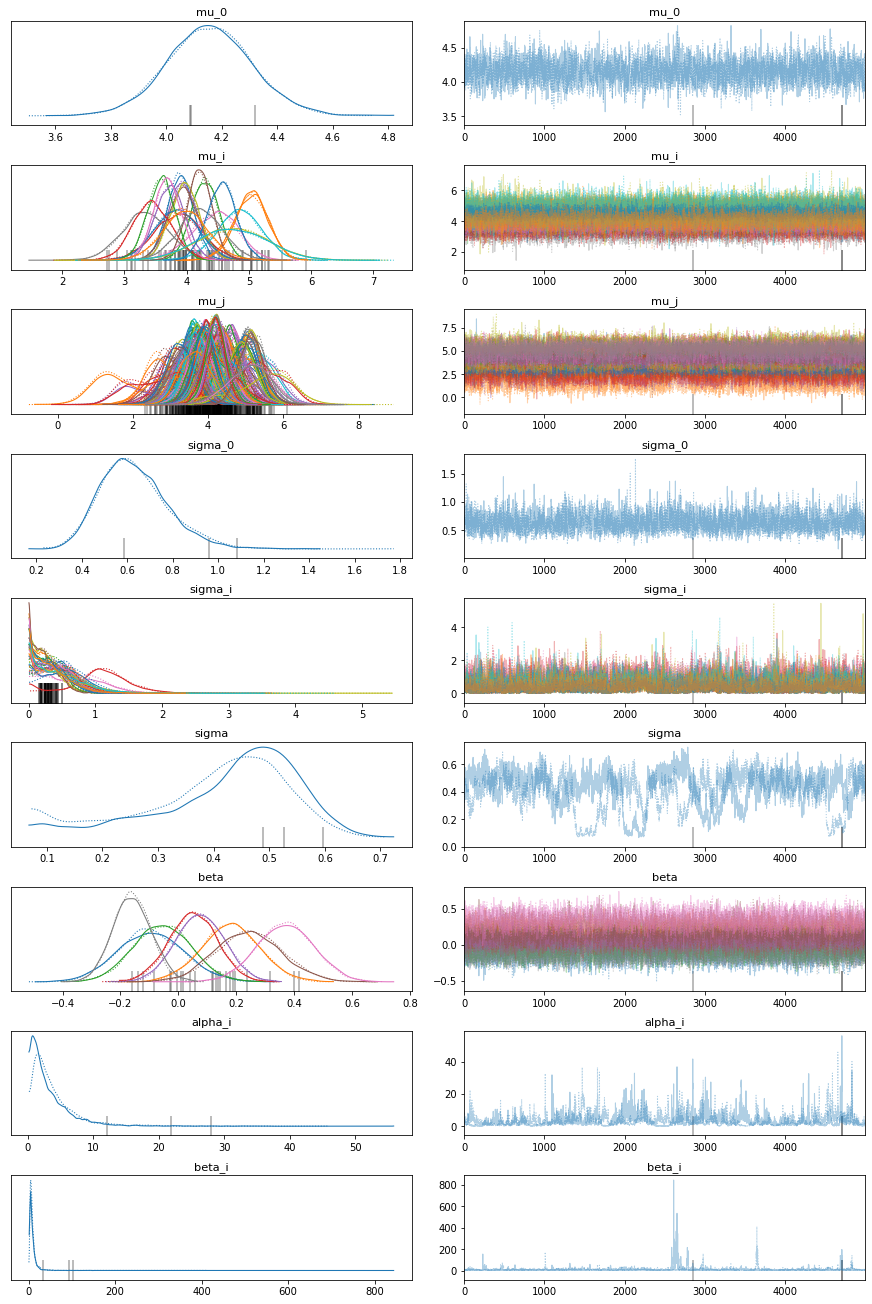

In [9]:
az.plot_trace(trace, var_names=['mu_0', 'mu_i', 'mu_j', 'sigma_0', 'sigma_i', 'sigma', 'beta', 'alpha_i', 'beta_i'])

#### _LOO PIT_

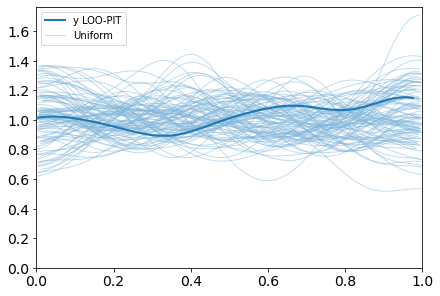

In [10]:
import matplotlib.pyplot as plt
az.plot_loo_pit(idata, y='y')
plt.savefig('plot/loo_pit/consumption.pdf')

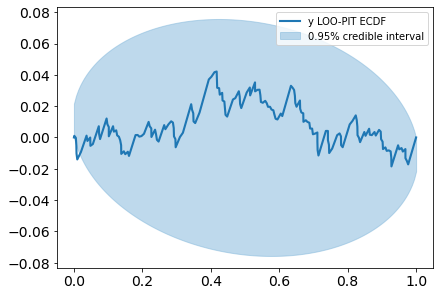

In [11]:
az.plot_loo_pit(idata, y='y', ecdf=True, hdi_prob=0.95)
plt.savefig('plot/loo_pit/consumption_ecdf.pdf')

In [12]:
idata.to_netcdf('output/inference/consumption.nc')

'output/inference/consumption.nc'

# Summary

In [13]:
summary_coef = np.quantile(trace.beta, axis=0, q=[0.5, 0.05, 0.25, 0.75, 0.95])
summary_coef = pd.DataFrame(np.transpose(summary_coef))
summary_coef.index = X.columns[:-1]
summary_coef.columns = ['median', 'lower90', 'lower50', 'upper50', 'upper90']
summary_coef['rhat'] = az.rhat(trace).beta
summary_coef = summary_coef.drop(index=x_nuisance.columns)
summary_coef

/Users/shinn1/.pyenv/versions/pixel/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars


,median,lower90,lower50,upper50,upper90,rhat
mean_educ,-0.097596,-0.281098,-0.172576,-0.019068,0.094053,1.001124
sat_model_est_wealth,0.180382,0.014849,0.113934,0.245786,0.343864,1.000287
gender_equality,-0.054231,-0.218486,-0.122843,0.012897,0.108951,1.000051
language_diversity,0.051669,-0.086595,-0.004150,0.107590,0.186012,1.000692
cultural_hegemony,0.075099,-0.061632,0.018316,0.132659,0.213081,1.000912
working_percent_un,0.243625,0.059407,0.166977,0.319880,0.433497,1.000621
mean_voice_account,0.369793,0.208218,0.303347,0.435381,0.531985,1.000732


In [14]:
summary_coef.to_csv('output/coef/coef_consumption.csv', index=True)

#### _Plot_

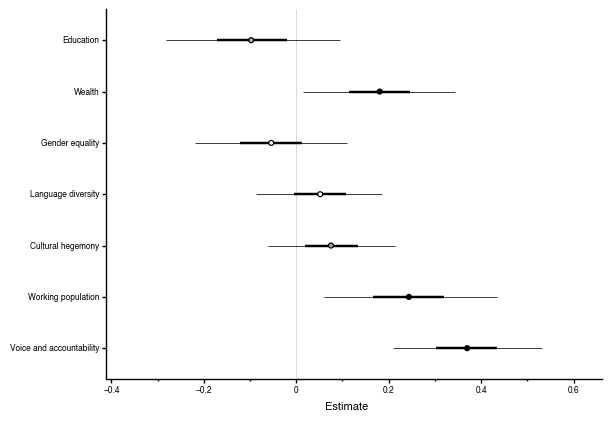

<ggplot: (334616165)>

In [15]:
summary_coef['var_name'] = cov_name
summary_coef = summary_coef[::-1]
summary_coef['var_name'] = pd.Categorical(summary_coef['var_name'], categories=summary_coef['var_name'])

# point color
foo = zip(summary_coef.lower90 * summary_coef.upper90, summary_coef.lower50 * summary_coef.upper50)
col = ['#000000' if x1 > 0 else '#aaaaaa' if x2 > 0 else '#ffffff' for (x1, x2) in foo]

# axis range
min_val = summary_coef.lower90.min()
max_val = summary_coef.upper90.max()
min_range = min_val - (max_val - min_val) * 0.1
max_range = max_val + (max_val - min_val) * 0.1

p = ggplot(aes(x='var_name', y='median'), data=summary_coef) + \
    geom_hline(yintercept=0, colour='#cccccc', size=0.3) + \
    geom_errorbar(aes(ymin='lower90', ymax='upper90', size=1, width=0)) + \
    geom_errorbar(aes(ymin='lower50', ymax='upper50', size=2, width=0)) + \
    scale_size_continuous(range=[0.3,1]) + \
    geom_point(size=1.5, fill=col) + \
    scale_y_continuous(limits=[min_range, max_range]) + \
    labs(x='', y='Estimate') + \
    coord_flip() + \
    theme_classic() + \
    theme(axis_text=element_text(size=6, colour='black', family='Helvetica'),
        axis_title=element_text(size=8, colour='black', family='Helvetica'),
        axis_line=element_line(color='black'),
        axis_ticks=element_line(color='black'),
        legend_position='none')
p

In [16]:
ggsave(p, 'plot/coef/consumption.pdf', width=1.5, height=2.5)

#### _Nuisance_

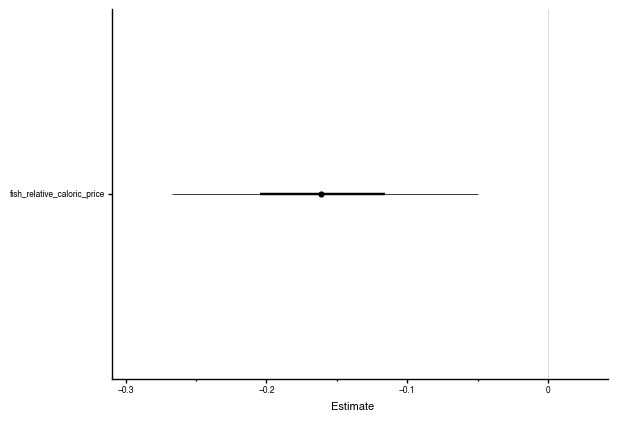

<ggplot: (335450677)>

In [17]:
summary_coef = np.quantile(trace.beta, axis=0, q=[0.5, 0.05, 0.25, 0.75, 0.95])
summary_coef = pd.DataFrame(np.transpose(summary_coef))
summary_coef.index = X.columns[:-1]
summary_coef.columns = ['median', 'lower90', 'lower50', 'upper50', 'upper90']
summary_coef = summary_coef.loc[x_nuisance.columns]

# plot
summary_coef['var_name'] = summary_coef.index
summary_coef['var_name'] = pd.Categorical(summary_coef['var_name'], categories=summary_coef['var_name'])

# point color
foo = zip(summary_coef.lower90 * summary_coef.upper90, summary_coef.lower50 * summary_coef.upper50)
col = ['#000000' if x1 > 0 else '#aaaaaa' if x2 > 0 else '#ffffff' for (x1, x2) in foo]

# axis range

min_val = min(0, summary_coef.lower90.min())
max_val = max(0, summary_coef.upper90.max())
min_range = min_val - (max_val - min_val) * 0.1
max_range = max_val + (max_val - min_val) * 0.1

p = ggplot(aes(x='var_name', y='median'), data=summary_coef) + \
    geom_hline(yintercept=0, colour='#cccccc', size=0.3) + \
    geom_errorbar(aes(ymin='lower90', ymax='upper90', size=1, width=0)) + \
    geom_errorbar(aes(ymin='lower50', ymax='upper50', size=2, width=0)) + \
    scale_size_continuous(range=[0.3,1]) + \
    geom_point(size=1.5, fill=col) + \
    scale_y_continuous(limits=[min_range, max_range]) + \
    labs(x='', y='Estimate') + \
    coord_flip() + \
    theme_classic() + \
    theme(axis_text=element_text(size=6, colour='black', family='Helvetica'),
        axis_title=element_text(size=8, colour='black', family='Helvetica'),
        axis_line=element_line(color='black'),
        axis_ticks=element_line(color='black'),
        legend_position='none')
p

In [18]:
ggsave(p, 'plot/nuisance/consumption.pdf', width=1.5, height=2.5)

# Deviation analysis

In [19]:
# estimates for regional mu and sigma
mu_i = np.quantile(trace.mu_i, axis=0, q=0.5)
sigma_i = np.quantile(trace.sigma_i, axis=0, q=0.5)

data = pd.DataFrame()
data['region_index'] = region_index
data['region'] = [region[x] for x in data.region_index]
data['country'] = df.loc[y_scaled.index, 'country_name_en'].values
data['iso3'] = df.loc[y_scaled.index, 'iso3c'].values
data['mu_j'] = np.quantile(trace.mu_j, axis=0, q=0.5)
data['mu_i'] = [mu_i[x] for x in data.region_index]
data['sigma_i'] = [sigma_i[x] for x in data.region_index]
data['sd'] = (data.mu_j - data.mu_i)/data.sigma_i
data['region_intercept'] = np.exp(data.mu_i) / scale_factor
data['nation_intercept'] = np.exp(data.mu_j) / scale_factor
data.head()

,region_index,region,country,iso3,mu_j,mu_i,sigma_i,sd,region_intercept,nation_intercept
0,12,Western Asia,United Arab Emirates,ARE,3.614601,3.591341,0.302933,0.076783,2.139168,2.189508
1,3,Southern Asia,Afghanistan,AFG,1.644237,3.858080,1.105300,-2.002933,2.793109,0.305231
2,0,Southern Europe,Albania,ALB,3.616060,3.894118,0.419173,-0.663348,2.895603,2.192705
3,12,Western Asia,Armenia,ARM,3.687341,3.591341,0.302933,0.316903,2.139168,2.354709
4,1,Middle Africa,Angola,AGO,5.178456,5.034246,0.251642,0.573076,9.055042,10.459719


In [20]:
data.to_csv('output/sd/sd_consumption.csv', index=False)